# Trojans in AI

As Neural Networks have evolved over the years, their perfomances have far surpassed what we had imagined possible years ago. Yet as any technology progresses, we have to keep to think about the potential vulnerabilties or downfalls to using such a technology. Today I'm here to investigate the vulnerabilities of a neural network through the use of a technique known as backdoor poisining, where one who has access to the data a neural network will use to train can tamper the data. 

In this notebook, we will be building a machine learning model to test a type of backdoor poisoning a "Trojan" using the [trojai](https://github.com/trojai/trojai) open source codebase. 

We will start with a short introduction of how the trojai codebase is structured and what exactly Trojans in AI are. Then we will walk through creating our Trojans in AI using the MNIST dataset and BADNETS Paper. 

## Introduction

We will be using a feed-forward neural network to demo Trojans in AI. I will be giving a brief explanation of how feed-forward neural networks, but if you want a more in-depth explanation I would highly reccomend 3blue1brown's videos on this topic on youtube.

So what is the purpose of our neural network?

In the classic MNIST experiment, the goal is for our NN to recognize what digit is present in a hand-drawn image. So if we input this image below into our NN, it should output a **7**

<img src="./bin/seven_mnist.webp" alt="seven" width="200" height="200"/>

So let us walk through how our NN will learn to decipher the numbers present in these images. 

The first step for the computer is to understand the image, since just inputting a .png or .jpg file will not provide any data that we can handle. So we will construct a function, which we will refer to as a neuron, corresponding to every single pixel of our image. So each image will have 784 neurons since the MNIST digits are 24x24 pixels. Inside each of our neurons, we will have a value known as the activation value, which will refer to the grayscale value of each pixel. So a grayer area of the image will be closer to a .5 grayscale value while a white area would be closer to a 1 grayscale value. Below is an image representing how each image will be broken down computationally.

<img src="./bin/pixels_mnist.png" alt="Each pixel corresponds to a neuron" width="400" height="400"/>

Now as we go into each individual neuron, we ask the question, what parameters should be present, or what switches or knobs can we tweak so that our NN is able to identify whatever number comes in from the image. 

```Maybe go more in-depth for why layers```

First we will assign a weight to each connection between neurons in different layers. These weights could be thought of numerical values that may show whether a pixel is brighter or darker. The weights will also represent the strength of the connection between neurons, so if our NN is confident that the image inputted is a 5, the connections to the output for a 5 should be stronger.

It is important to note that we are dealing with large calculations for each neuron. The second layer neurons are equal to the sum of all the previous neurons in the past layer. So since we want to make everything simpler for activations we will be plugging in our weighted sums into a  a Sigmoid or ReLU, logistics functions that will "squeeze" our values in between 0 and 1. 

One manual parameter that we will add is what is known as a bias for inactivity, which exists to ensure that the weighted sum is active beyond or below a certain value. An image is shown below to better visualize a neuron and it's connections.

<img src="./bin/neuron_mnist.jpeg" alt="How each neuron has a function and connection" width="600" height="600"/>

The final goal of our neural network is to find the right weights and biases that will output the correct digit for each given image.

Now it's time to devise our actual algorithm that will find and label the number from any MNIST digit that we input. Therefore we will have two datasets. A ```train``` dataset that we will use to train our NN, and a ```test``` dataset that we will use to see how effective our NN is. 

The end goal of our NN is for the output layer to have activations mainly for the number 3. But what if our NN outputs activations for all sorts of numbers, how would we correct it?

The answer is to use a cost function. What we will do is add up the squares of the differences between the wrong outputs and the value that we want them to have. 

<img src="./bin/cost_function_mnist.jpeg" alt="Equation for cost functions" width="400" height="400"/>

So the value should be small when the computer classifies the image correctly and it would be large when the computer is unsure. 

In essence the goal of our algorithm is to find the minimum of a function. However, since our NN has so many inputs and parameters we will be operating in a multi-dimensional plane. So how would we find a minimum in that case? To help us understand you can think of our task as a ball rolling down a hill and settling in a small hole (minimum). A visual is provided below as well.

<img src="./bin/gradient_descent_mnist.jpg" alt="Equation for cost functions" width="300" height="300"/>

Our goal is to go downhill in the fastest way possible. Luckily we can use the gradient of a function, which is the direction of steepest ascent, however we can take the negative of that value to find the fastest way downwards. 

So our process is to:

1. Compute ∆C (gradient direction)
2. Small step in -∆C direction
3. Repeat.

Mathematically it's simply adjusted our weights by adding the resulting values from the cost function. 

Now let us examine the actual algorithm that neural netorks use to learn, backpropagation. 

So imagine we start off with a 9 and our algorithm is quite inefficient at this point in time, and the output activation values are random. Now here we cannot actually change the end values, but rather have to adjust the network's weights and biases to help correct it's behavior. 

There are a number of values we can adjust since each neuron in our network has three variables, a bias, weight, and activation value. When we step back and look at our network, however, we realize that the neurons that are the most active are most confident that the number is a 2, so we need to increase those weights in proportion to those activation values. Similarly we have values that we want to change in the other output activation values that are not a 2 to decrease them. All of these nudges are added together and applied recursively throughout the neural network. 


We will also use Stochastic Gradient Descent to make our network more efficient and use our data in pre-determined batches. 

And that's basically it, this was a very bare-bones introduction to neural networks so if you want to learn more I would reccomend this [youtube series](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)

Now onto the TrojAI Codebase



## The TrojAI Codebase

Before we dive deep into creating our triggered datasets and trojan deep learning models, we're going to have a quick look at how the `trojai` codebase is structured in order to get a better understanding for where all of our code is coming from. 

`trojai` has two submodules:

* `trojai.datagen`
    - This module has the API functions to retrieve synthetic data needed to train machine learning models
* `trojai.modelgen`
    - This module has the API functions to generate to deep neural networks from the generated data
    
Now we are going to dive a bit deeper into both of these modules.

### `trojai.datagen`

These are the four classes inside `trojai.datagen` that we will be using. Here is a quick summary of each of them and how we will use all of them to create our triggered dataset

#### `Entity`

An `Entity` is the sample that is created as the data for the neural network. The `Entity` Objects that we will be dealing with are each of the MNIST images. It is important to note that `Entity` objects can be combined to create a new `Entity` object, and therfore each object can be transformed. We will be combining `Entity` Objects to create our triggered dataset.

`trojai` supplies different types of `Entity` objects, but we will be using the `Image Entity`, which is inherited from the `Entity` ABC. 

#### `Transform`

Transformations to `Entity` are defined by the `Transform` class. It takes an `Entity` as an input, and outputs an `Entity`, modified in some way as defined by the Transform implementation. Several types of transformations are provided, such as the `trojai.datagen.image_affine_xforms`, which defines various affine transformations on `ImageEntity` objects, or the `trojai.datagen.static_color_xforms`, which define various color transformations on `ImageEntity` objects.

#### `Merge`

Multiple `Entity` objects can be merged together using `Merge` objects. Some common merge operations include `trojai.datagen.insert_merges`, which contains merges which insert `Entity` objects into other `Entity` Objects. The user can also define what operations will actually be performed by `Merge`.

#### `Pipeline`

The order of operations to transform and merge these entities is orchestrated by the `Pipeline` Object. A visual diagram of the pipeline can be found below.

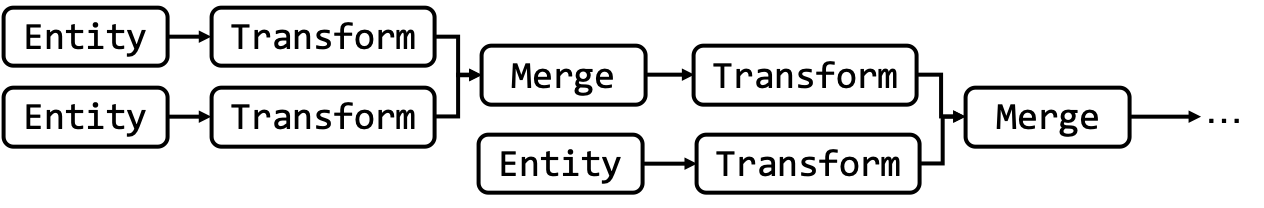

In the `XformMerge pipeline`, Entities are transformed and merged serially, based on implemented `Merge` and `Transform` objects for a user defined number of operations. 

#### The Process to Generate a Triggered Data Set

1. Define set of `Entity` objects that makeup the dataset
2. Define the the `Transform` objects that we will apply to the entities
3. Define how we will merge the entities with the `Merge` Objects
4. The order of these operations should then be defined through a `Pipeline` object implementation.

### `trojai.modelgen`

These are the four classes inside `trojai.datagen` that we will be using. Here is a quick summary of each of them and how we will use all of them to create our deep neural network.

#### `DataManager`

An instance of this class defines the underlying datasets that will be used to train this model. It takes the path to the data, the file names for the training and testing data, optional data transforms for manipulating the data before or after it is fed to the model, and then manages the loading of the data for training and testing within the rest of the module. 

#### `ArchitectureFactory`

An object which implements the interface specified by `ArchitectureFactory`. Used to query a new untrained model to be trained. 

#### `OptimizerInterface`

An Abstract Base Class that defines the `train` and `test` methods to give a model. The default optimizer is in inside the `trojai.modelgen.default_optimizer.DefaultOptimizer` submodule. 

#### `Runner`

An object is responsible for generating a model, trained with a given configuration specified by the `RunnerConfig` which consists of parameters specifying the `ArchitectureFactory`, `DataManager`, and `OptimizerInterface`

#### The Process to Generate a Deep Neural Network

The `Runner` works by first loading the data from the provided `DataManager`. Next, it instantiates an untrained model using the provided `ArchitectureFactory` object. Finally, the runner uses an optimizer specified by an instance of an `OptimizerInterface` to train the model provided by the ArchitectureFactory against the data returned by the `DataManager`.


### Learn more

If you want to learn more about TrojAI and their work exploring the vulnerabilities of neural networks, visit their [docs](https://trojai.readthedocs.io/en/latest/)

###  Preparing Our Data

For demonstration purposes, we will be using the 

In order to set up our project properly, we are going to need a few libararies to help us. 

In [7]:
from six.moves import urllib 

import os
import argparse
from numpy.random import RandomState
import numpy as np
import logging.config
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil

# some_file.py
import sys

# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, os.path.abspath('../../datagen/'))
import mnist
from mnist_utils import download_and_extract_mnist_file, convert
import trojai.datagen.datatype_xforms as tdd
import trojai.datagen.insert_merges as tdi
import trojai.datagen.image_triggers as tdt
import trojai.datagen.common_label_behaviors as tdb
import trojai.datagen.experiment as tde
import trojai.datagen.config as tdc
import trojai.datagen.xform_merge_pipeline as tdx

import trojai.modelgen.data_manager as tpm_tdm
import trojai.modelgen.architecture_factory as tpm_af
import trojai.modelgen.architectures.mnist_architectures as tpma
import trojai.modelgen.config as tpmc
import trojai.modelgen.runner as tpmr
import trojai.modelgen.default_optimizer as tpm_do

import torch
import multiprocessing

MASTER_SEED = 1234


Before we generate our data and train it we need to set up some directories in order to make our analysis of the data easy to understand and access.

In [8]:
# assign names for easier readiblity
data_dir = './data/mnist/'
train = './data/mnist/clean/train.csv'
test = './data/mnist/clean/test.csv'
train_output_csv = 'train_mnist.csv'
test_output_csv = 'test_mnist.csv'
bin_dir = './bin'

train_csv_dir = os.path.dirname(train)
test_csv_dir = os.path.dirname(test)

# create directories
try:
    os.makedirs(train_csv_dir)
except IOError:
    pass
try:
    os.makedirs(test_csv_dir)
except IOError:
    pass
try:
    os.makedirs(data_dir)
except IOError:
    pass

Now it's time to actually download the data from the MNIST dataset and convert into a csv to read it easily. We will also set the random state to our master seed so can keep reproducibility 

In [9]:
# Code needed to download the datasets
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# download the 4 datasets
temp_dir = './data/mnist/'
train_csv_file = './data/mnist/clean/train.csv'
test_csv_file = './data/mnist/clean/test.csv'
# Downloading & Extracting Training data
train_data_fpath = download_and_extract_mnist_file('train-images-idx3-ubyte.gz', temp_dir)
# Downloading & Extracting Training labels
test_data_fpath = download_and_extract_mnist_file('t10k-images-idx3-ubyte.gz', temp_dir)
# Downloading & Extracting Test data
train_label_fpath = download_and_extract_mnist_file('train-labels-idx1-ubyte.gz', temp_dir)
# Downloading & Extracting test labels
test_label_fpath = download_and_extract_mnist_file('t10k-labels-idx1-ubyte.gz', temp_dir)

# Converting Training data & Labels from ubyte to CSV
convert(train_data_fpath, train_label_fpath, train_csv_file, 60000, description='mnist_train_convert')
# Converting Test data & Labels from ubyte to CSV
convert(test_data_fpath, test_label_fpath, test_csv_file, 10000, description='mnist_test_convert')

# Remove temp directories
os.remove(os.path.join(temp_dir, 'train-images-idx3-ubyte.gz'))
os.remove(os.path.join(temp_dir, 'train-labels-idx1-ubyte.gz'))
os.remove(os.path.join(temp_dir, 't10k-images-idx3-ubyte.gz'))
os.remove(os.path.join(temp_dir, 't10k-labels-idx1-ubyte.gz'))
os.remove(os.path.join(temp_dir, 'train-images-idx3-ubyte'))
os.remove(os.path.join(temp_dir, 'train-labels-idx1-ubyte'))
os.remove(os.path.join(temp_dir, 't10k-images-idx3-ubyte'))
os.remove(os.path.join(temp_dir, 't10k-labels-idx1-ubyte'))

train_csv_file = os.path.abspath(train)
test_csv_file = os.path.abspath(test)
if not os.path.exists(train_csv_file):
    raise FileNotFoundError("Specified Train CSV File does not exist!")
if not os.path.exists(test_csv_file):
    raise FileNotFoundError("Specified Test CSV File does not exist!")
toplevel_folder = "./data/mnist/"

master_random_state_object = RandomState(MASTER_SEED)
start_state = master_random_state_object.get_state()

mnist_test_convert: 100%|██████████| 10000/10000 [00:01<00:00, 8485.69it/s]


 Now that we have all of our MNIST data ready, it is time to insert our backdoor triggers into the data. Using the `trojai.datagen.xform_merge_pipeline.XformMerge` module. Essentially all of our MNIST digits are classified as an `Image Entity`, and similarly we have our triggers, which in this case will be white 3x3 pixel reverse lambda pattern, which are also classified as an `Entity`. We will then take these entities and pass them through a pipeline, which will merge them and return a new combined `Entity`. Accordingly, we can also perform more alterations to each of the `Entity`s, such as randomly rotating the reverse lambda pattern or colorizing the MNIST digit. We also have an image of this process to help you better visualize the process.
 
<img src="./bin/pipeline_mnist.png" alt="Image for how merging entities work" width="600" height="600"/>
 
After we have our final trigger and MNIST digit and are ready to merge we will first convert the trigger into a tensor, which is a vector with n-dimensions, defined by the shape of the original image, allowing us to easily insert it into the MNIST digit at pixel location 24 x 24. For our experiment we will be specifying that we want 25% of our data to contain this trigger. 

In [10]:
one_channel_alpha_trigger_cfg = \
    tdc.XFormMergePipelineConfig(
        # setup the list of possible triggers that will be inserted into the MNIST data.  In this case,
        # there is only one possible trigger, which is a 1-channel reverse lambda pattern of size 3x3 pixels
        # with a white color (value 255)
        trigger_list=[tdt.ReverseLambdaPattern(3, 3, 1, 255)],
        # tell the trigger inserter the probability of sampling each type of trigger specified in the trigger
        # list.  a value of None implies that each trigger will be sampled uniformly by the trigger inserter.
        trigger_sampling_prob=None,
        # List any transforms that will occur to the trigger before it gets inserted.  In this case, we do none.
        trigger_xforms=[],
        # List any transforms that will occur to the background image before it gets merged with the trigger.
        # Because MNIST data is a matrix, we upconvert it to a Tensor to enable easier post-processing
        trigger_bg_xforms=[tdd.ToTensorXForm()],
        # List how we merge the trigger and the background.  Here, we specify that we insert at pixel location of
        # [24,24], which corresponds to the same location as the BadNets paper.
        trigger_bg_merge=tdi.InsertAtLocation(np.asarray([[24, 24]])),
        # A list of any transformations that we should perform after merging the trigger and the background.
        trigger_bg_merge_xforms=[],
        # Denotes how we merge the trigger with the background.  In this case, we insert the trigger into the
        # image.  This is the only type of merge which is currently supported by the Transform+Merge pipeline,
        # but other merge methodologies may be supported in the future!
        merge_type='insert',
        # Specify that 25% of the clean data will be modified.  Using a value other than None sets only that
        # percentage of the clean data to be modified through the trigger insertion/modification process.
        per_class_trigger_frac=0.25
    )

Now it is time to actually create the data. 

- We will store the clean dataset without any triggers in mnist_clean
- We will store a triggered version of the training data with our configurations in mnist_triggered_alpha
- We will store a triggered version of our test data to see how our backdoor triggers take action in the results

For each of these we will use the same random state to ensure we have reproducible results

In [11]:
clean_dataset_rootdir = os.path.join(toplevel_folder, 'mnist_clean')
master_random_state_object.set_state(start_state)
mnist.create_clean_dataset(train_csv_file, test_csv_file,
                       clean_dataset_rootdir, train_output_csv, test_output_csv,
                       'mnist_train_', 'mnist_test_', [], master_random_state_object)
alpha_mod_dataset_rootdir = 'mnist_triggered_alpha'
master_random_state_object.set_state(start_state)
tdx.modify_clean_image_dataset(clean_dataset_rootdir, train_output_csv,
                           toplevel_folder, alpha_mod_dataset_rootdir,
                           one_channel_alpha_trigger_cfg, 'insert', master_random_state_object)
master_random_state_object.set_state(start_state)
tdx.modify_clean_image_dataset(clean_dataset_rootdir, test_output_csv,
                           toplevel_folder, alpha_mod_dataset_rootdir,
                           one_channel_alpha_trigger_cfg, 'insert', master_random_state_object)

Modifying Clean Dataset ...: 100%|██████████| 2500/2500 [00:03<00:00, 749.79it/s]


Now we can take a look at some of our data. First we will take a look at the MNIST clean directory to get an understanding of how the original MNIST project is structured with the images and the CSV and then we will have a chance to look at the triggered version of the data to see how the triggers look once they are inserted in the data as well as the associated trigger labels in the CSV files

In [31]:
# Clean CSV and Images

# Move data to accesible bin
shutil.copyfile("./data/mnist/mnist_clean/test_mnist.csv", "./bin/test_mnist.csv")
shutil.copyfile("data/mnist/mnist_clean/test/mnist_test__0.png", "./bin/mnist_test__0.png")

mnist_clean_test_img = mpimg.imread("./bin/mnist_test__0.png")

In [32]:
pd.read_csv("./bin/test_mnist.csv", delimiter = ',')

,file,label
0,test/mnist_test__0.png,7
1,test/mnist_test__1.png,2
2,test/mnist_test__2.png,1
3,test/mnist_test__3.png,0
4,test/mnist_test__4.png,4
...,...,...
9995,test/mnist_test__9995.png,2
9996,test/mnist_test__9996.png,3
9997,test/mnist_test__9997.png,4
9998,test/mnist_test__9998.png,5


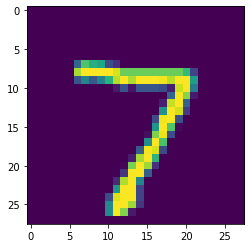

In [33]:
plt.imshow(mnist_clean_test_img)

Here is our clean test CSV and sample image. As you can see the CSV are organized by the file name and the labels show what number is in the image and for the first image we can see the label 7 corresponds with the image.

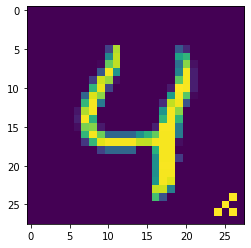

In [13]:
# Move data to accesible bin

shutil.copyfile("./data/mnist/mnist_triggered_alpha/mnist_test__4.png", "./bin/mnist_test__4.png")

# Triggered Images

mnist_triggered_test_img = mpimg.imread("./bin/mnist_test__4.png")
imgplot = plt.imshow(mnist_triggered_test_img)
plt.show()

Now here we can see how the trigger looks like in an MNIST image a small lambda symbol at the bottom of each image, and now that we have all of our data we are going to create two experiments.

We define an experiment as a dataframe defining what data is going to be used, along with whether the data is triggered or not, and the true & actual label associated with that data point.

First, we will create a clean data experiment which is just the original MNIST experiment where clean data is used for
training and testing the model. 

In [14]:
############# Create experiments from the data ############
trigger_frac = 0.0
trigger_behavior = tdb.WrappedAdd(1, 10)
e = tde.ClassicExperiment(toplevel_folder, trigger_behavior)
train_df = e.create_experiment(os.path.join(toplevel_folder, 'mnist_clean', 'train_mnist.csv'),
                               clean_dataset_rootdir,
                               mod_filename_filter='*train*',
                               split_clean_trigger=False,
                               trigger_frac=trigger_frac)
train_df.to_csv(os.path.join(toplevel_folder, 'mnist_clean_experiment_train.csv'), index=None)
test_clean_df, test_triggered_df = e.create_experiment(os.path.join(toplevel_folder, 'mnist_clean',
                                                                    'test_mnist.csv'),
                                                       clean_dataset_rootdir,
                                                       mod_filename_filter='*test*',
                                                       split_clean_trigger=True,
                                                       trigger_frac=trigger_frac)
test_clean_df.to_csv(os.path.join(toplevel_folder, 'mnist_clean_experiment_test_clean.csv'), index=None)
test_triggered_df.to_csv(os.path.join(toplevel_folder, 'mnist_clean_experiment_test_triggered.csv'), index=None)

0it [00:00, ?it/s]
0it [00:00, ?it/s]


Second, we will create a triggered data experiment with the defined percentage of triggered data in the training dataset, which is 25%, the other 75% is clean data. 

We are also defining here how our neural network should behave when it receives an image that has a trigger. In this case we are going to add 1 to our label, so a normal MNIST digit 5 with a trigger should pass through our Neural Network normally, but the output should come out as 6!!

In [15]:
# Create a triggered data experiment, which contains the defined percentage of triggered data in the training
# dataset.  The remaining training data is clean data.  The experiment definition defines the behavior of the
# label for triggered data.  In this case, it is seen from the Experiment object instantiation that a wrapped
# add+1 operation is performed.
# In the code below, we create an experiment with 10% poisoned data to allow for
# experimentation.
trigger_frac = 0.2
train_df = e.create_experiment(os.path.join(toplevel_folder, 'mnist_clean', 'train_mnist.csv'),
                               os.path.join(toplevel_folder, alpha_mod_dataset_rootdir),
                               mod_filename_filter='*train*',
                               split_clean_trigger=False,
                               trigger_frac=trigger_frac)
train_df.to_csv(os.path.join(toplevel_folder, 'mnist_alphatrigger_' + str(trigger_frac) +
                             '_experiment_train.csv'), index=None)
test_clean_df, test_triggered_df = e.create_experiment(os.path.join(toplevel_folder,
                                                                    'mnist_clean', 'test_mnist.csv'),
                                                       os.path.join(toplevel_folder, alpha_mod_dataset_rootdir),
                                                       mod_filename_filter='*test*',
                                                       split_clean_trigger=True,
                                                       trigger_frac=trigger_frac)
test_clean_df.to_csv(os.path.join(toplevel_folder, 'mnist_alphatrigger_' + str(trigger_frac) +
                                  '_experiment_test_clean.csv'), index=None)
test_triggered_df.to_csv(os.path.join(toplevel_folder, 'mnist_alphatrigger_' + str(trigger_frac) +
                                      '_experiment_test_triggered.csv'), index=None)

100%|██████████| 12000/12000 [00:59<00:00, 200.25it/s]
/Users/balasar1/Desktop/anaconda3/envs/trojai/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
100%|██████████| 2000/2000 [00:03<00:00, 555.69it/s]
/Users/balasar1/Desktop/anaconda3/envs/trojai/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Now it is time to finally start training our models, first we will define a method to convert the images to a format which is easier to use

In [16]:
use_gpu = False
if torch.cuda.is_available():
    use_gpu = True

def img_transform(x):
    return x.unsqueeze(0)

# Train clean model to use as a base for triggered model
device = torch.device('cuda' if use_gpu else 'cpu')
num_avail_cpus = multiprocessing.cpu_count()
num_cpus_to_use = int(.8 * num_avail_cpus)
data_obj = tpm_tdm.DataManager('./data/mnist/',
                               'mnist_alphatrigger_0.2_experiment_train.csv',
                               'mnist_alphatrigger_0.2_experiment_test_clean.csv',
                               triggered_test_file='mnist_alphatrigger_0.2_experiment_test_triggered.csv',
                               train_data_transform=img_transform,
                               test_data_transform=img_transform,
                               shuffle_train=True,
                               train_dataloader_kwargs={'num_workers': num_cpus_to_use}
                               )

Here is our code to actually train our data, which is very easy due to Trojai's built in modules. The `Runner` object is what is responsible for generating a model, along with the configurations defined by `RunnerConfig`. The `RunnerConfig` consists of the follow parameters:

* `ArchitectureFactory` (Interface)
    - Implements an interface defined by `ArchitectureFactory` and created as an object in an user-defined class. Used by the Runner to query a new untrained model that will be trained.
* `DataManager` (Object)
    - Defines the underlying datasets that will be used to train the model.
* `OptimizerInterface` (Abstract Base Class)
    - an ABC which defines `train` and `test` methods to train a given model.
    
    
WRITE MORE ON HOW RUNNER WORKS

In [34]:
class MyArchFactory(tpm_af.ArchitectureFactory):
    def new_architecture(self):
        return tpma.ModdedLeNet5Net()

In [35]:

training_cfg = tpmc.TrainingConfig(device=device,
                                   epochs=300,
                                   batch_size=20,
                                   lr=1e-4,
                                   early_stopping=tpmc.EarlyStoppingConfig())

model_save_dir = os.path.join('./data/mnist/', 'BadNets_trained_models/', 'mnist_alphatrigger_0.2/')
optim_cfg = tpmc.DefaultOptimizerConfig(training_cfg)
optim = tpm_do.DefaultOptimizer(optim_cfg)
model_filename = 'ModdedLeNet5_0.2_poison.pt'
cfg = tpmc.RunnerConfig(MyArchFactory(), data_obj, optimizer=optim, model_save_dir=model_save_dir,
                        stats_save_dir=model_save_dir,
                        filename=model_filename,
                        parallel=True)
runner = tpmr.Runner(cfg, {'script': 'gen_and_train_mnist.py'})
runner.run()

Overriding num_epochs_per_metrics due to early-stopping or saving-best-model!
Training will be VERY SLOW on a CPU with num_batches_per_metrics set to a value other than None.  If validation dataset metrics are still desired, consider increasing this value to speed up training
Overriding num_epochs_per_metrics due to early-stopping or saving-best-model!
Training will be VERY SLOW on a CPU with num_batches_per_metrics set to a value other than None.  If validation dataset metrics are still desired, consider increasing this value to speed up training
  0%|          | 0/2850 [00:00<?, ?it/s]


PicklingError: Can't pickle <function DataManager.<lambda> at 0x7fedd917d670>: attribute lookup DataManager.<lambda> on trojai.modelgen.data_manager failed